In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import vgg16

In [2]:
def add_layers(bottom_model):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(3, activation='softmax')(top_model)
    return top_model

transfer learning vgg16, resnet50, inception

In [3]:
model = vgg16.VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape= (224,224,3))

In [4]:
for layer in model.layers:
    layer.trainable = False

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2,2),
    
#     tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(50, activation='relu'),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [7]:
FC_Head = add_layers(model)

model = Model(inputs = model.input, outputs = FC_Head)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
training_dir = 'split/train'

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range = 40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(training_dir,
                                                   batch_size=25,
                                                   target_size=(224,224))

test_dir = 'split/test'

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=25,
                                                 target_size=(224,224))

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta=0,
                         patience=3,
                         restore_best_weights = True)

Found 130046 images belonging to 3 classes.
Found 37160 images belonging to 3 classes.


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [11]:
history = model.fit(train_generator,
                             epochs=30,
                             validation_data=test_generator,
                             callbacks=[checkpoint, earlystop])

Epoch 1/30
5202/5202 [==============================] - 3163s 607ms/step - loss: 0.1625 - acc: 0.9377 - val_loss: 0.0698 - val_acc: 0.9758
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/30
5202/5202 [==============================] - 3119s 600ms/step - loss: 0.1063 - acc: 0.9610 - val_loss: 0.0549 - val_acc: 0.9801
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/30
5202/5202 [==============================] - 3113s 598ms/step - loss: 0.0940 - acc: 0.9659 - val_loss: 0.0492 - val_acc: 0.9828
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/30
5202/5202 [==============================] - 3133s 602ms/step - loss: 0.0851 - acc: 0.9687 - val_loss: 0.0496 - val_acc: 0.9811
Epoch 5/30
5202/5202 [==============================] - 3553s 683ms/step - loss: 0.0805 - acc: 0.9709 - val_loss: 0.0432 - val_acc: 0.9847
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/30
5202/5202 [==============================] - 3358s 645ms/step 

In [12]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


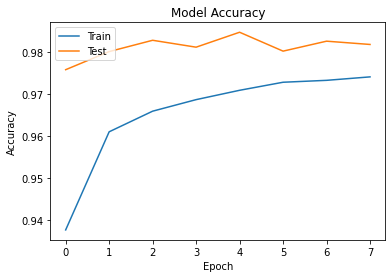

In [13]:
## Summarize accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.savefig('model_acc.png', dpi=200, format='png')

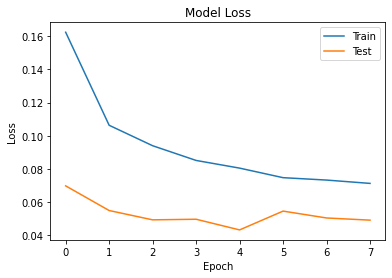

In [14]:
## Summarize loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
plt.savefig('model_loss.png', dpi=200, format='png')